In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sakshaymahna/cityscapes-depth-and-segmentation")

print("Path to dataset files:", path)

100%|██████████| 642M/642M [00:11<00:00, 57.5MB/s] 

Extracting model files...


Path to dataset files: /localhome/aaa324/.cache/kagglehub/datasets/sakshaymahna/cityscapes-depth-and-segmentation/versions/1


In [3]:
import os
cmd = f"mv {path} ./"

os.system(cmd)

0

In [4]:
%mv ./1/data ./data

In [5]:
%rm -r ./1

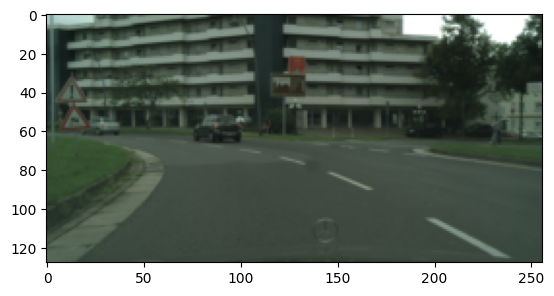

In [12]:
import numpy as np
from matplotlib import pyplot as plt

x = np.load("./data/train/image/0.npy")
x = x*255
x = x.astype(np.uint8)
plt.imshow(x)

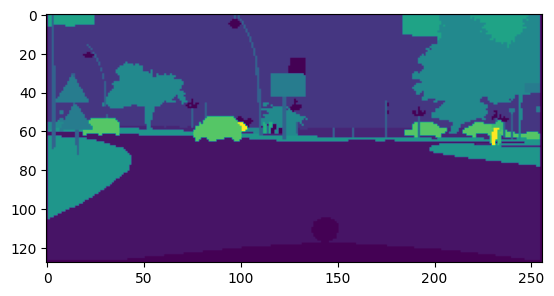

In [13]:
x = np.load("./data/train/label/0.npy")
plt.imshow(x)

In [52]:
import torch
from torch.utils.data import Dataset, DataLoader
from natsort import natsorted
import os 

class CityScapes(Dataset):
    def __init__(self, main_dir, transforms=None):
        self.main_dir = main_dir
        self.transforms = transforms
        image_dir = os.path.join(main_dir, 'image')
        self.images = []
        for file in natsorted(os.listdir(image_dir)):
            self.images.append(file)
        label_dir = os.path.join(main_dir, 'label')
        self.labels = []
        for file in natsorted(os.listdir(image_dir)):
            self.labels.append(file)

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image_path = os.path.join(self.main_dir, 'image', self.images[index])
        label_path = os.path.join(self.main_dir, 'label', self.images[index])
        image, label = np.load(image_path), np.load(label_path)
        if self.transforms is not None:
            transformed = self.transforms(image=image, mask=label)
            image, label = transformed['image'], transformed['mask']
            label = torch.where(label==13, 1, 0)
        return image, label

In [53]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import random_split

train_transforms = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(),
    A.Rotate(limit=10, p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    ToTensorV2()
])
test_transforms = A.Compose([
    A.Resize(224, 224),
    ToTensorV2()
])
train_dataset = CityScapes("./data/train", transforms=train_transforms)
train_dataset, valid_dataset = random_split(train_dataset, (0.9, 0.1))
test_dataset = CityScapes("./data/val", transforms=test_transforms)


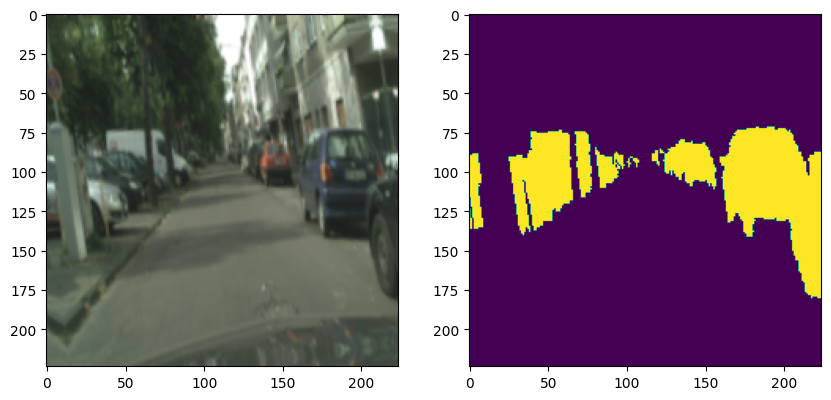

In [57]:
img, label = train_dataset[10]
# plt.imshow(label)
img = img.permute(1,2,0)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
axes[0].imshow(img.cpu().numpy())
axes[1].imshow(label)

In [58]:
import torch.nn as nn

def simple_block(in_channel, out_channel):
    return nn.Sequential(
        nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channel),
        nn.ReLU()
    )

In [110]:
weight = torch.load("./vgg16_bn-6c64b313.pth")
for item in weight.items():
    print(item[0], item[1].shape)

features.0.weight torch.Size([64, 3, 3, 3])
features.0.bias torch.Size([64])
features.1.weight torch.Size([64])
features.1.bias torch.Size([64])
features.1.running_mean torch.Size([64])
features.1.running_var torch.Size([64])
features.3.weight torch.Size([64, 64, 3, 3])
features.3.bias torch.Size([64])
features.4.weight torch.Size([64])
features.4.bias torch.Size([64])
features.4.running_mean torch.Size([64])
features.4.running_var torch.Size([64])
features.7.weight torch.Size([128, 64, 3, 3])
features.7.bias torch.Size([128])
features.8.weight torch.Size([128])
features.8.bias torch.Size([128])
features.8.running_mean torch.Size([128])
features.8.running_var torch.Size([128])
features.10.weight torch.Size([128, 128, 3, 3])
features.10.bias torch.Size([128])
features.11.weight torch.Size([128])
features.11.bias torch.Size([128])
features.11.running_mean torch.Size([128])
features.11.running_var torch.Size([128])
features.14.weight torch.Size([256, 128, 3, 3])
features.14.bias torch.Siz

In [122]:
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, input_channel=3):
        super().__init__()
        self.encoder1 = nn.Sequential(
            simple_block(input_channel, 64),
            simple_block(64, 64),
        )
        self.encoder2 = nn.Sequential(
            simple_block(64, 128),
            simple_block(128, 128),
        )
        self.encoder3 = nn.Sequential(
            simple_block(128, 256),
            simple_block(256, 256),
            simple_block(256, 256),
        )
        self.encoder4 = nn.Sequential(
            simple_block(256, 512),
            simple_block(512, 512),
            simple_block(512, 512),
        )
        self.encoder5 = nn.Sequential(
            simple_block(512, 512),
            simple_block(512, 512),
            simple_block(512, 512),
        )
    
    def forward(self, data):
        x = self.encoder1(data)
        x, id1 = F.max_pool2d(x, kernel_size=2, stride=2, return_indices=True)
        x = self.encoder2(x)
        x, id2 = F.max_pool2d(x, kernel_size=2, stride=2, return_indices=True)
        x = self.encoder3(x)
        x, id3 = F.max_pool2d(x, kernel_size=2, stride=2, return_indices=True)
        x = self.encoder4(x)
        x, id4 = F.max_pool2d(x, kernel_size=2, stride=2, return_indices=True)
        x = self.encoder5(x)
        x, id5 = F.max_pool2d(x, kernel_size=2, stride=2, return_indices=True)
        
        return x, [id1, id2, id3, id4, id5]

In [123]:
class Decoder(nn.Module):
    def __init__(self, output_channel=2):
        super().__init__()
        self.decoder1 = nn.Sequential(
            simple_block(512, 512),
            simple_block(512, 512),
            simple_block(512, 512),
        )
        self.decoder2 = nn.Sequential(
            simple_block(512, 512),
            simple_block(512, 512),
            simple_block(512, 256),
        )
        self.decoder3 = nn.Sequential(
            simple_block(256, 256),
            simple_block(256, 256),
            simple_block(256, 128),
        )
        self.decoder4 = nn.Sequential(
            simple_block(128, 128),
            simple_block(128, 64),
        )
        self.decoder5 = nn.Sequential(
            simple_block(64, 64),
            simple_block(64, output_channel)
        )
    def forward(self, data, ids):
        reverted_ids = ids[::-1]
        x = F.max_unpool2d(data, indices=reverted_ids[0], kernel_size=2, stride=2)
        x = self.decoder1(x)
        x = F.max_unpool2d(x, indices=reverted_ids[1], kernel_size=2, stride=2)
        x = self.decoder2(x)
        x = F.max_unpool2d(x, indices=reverted_ids[2], kernel_size=2, stride=2)
        x = self.decoder3(x)
        x = F.max_unpool2d(x, indices=reverted_ids[3], kernel_size=2, stride=2)
        x = self.decoder4(x)
        x = F.max_unpool2d(x, indices=reverted_ids[4], kernel_size=2, stride=2)
        x = self.decoder5(x)
        return x

In [90]:
!wget https://download.pytorch.org/models/vgg16_bn-6c64b313.pth

--2024-11-01 12:00:02--  https://download.pytorch.org/models/vgg16_bn-6c64b313.pth
Resolving download.pytorch.org (download.pytorch.org)... 3.164.255.35, 3.164.255.101, 3.164.255.126, ...
Connecting to download.pytorch.org (download.pytorch.org)|3.164.255.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 553507836 (528M) [application/octet-stream]
Saving to: ‘vgg16_bn-6c64b313.pth’

vgg16_bn-6c64b313.p 100%[===================>] 527.87M   107MB/s    in 5.1s    

2024-11-01 12:00:07 (103 MB/s) - ‘vgg16_bn-6c64b313.pth’ saved [553507836/553507836]



In [124]:
class SegNet(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()
        self.encoder = self.load_encoder(in_channel)
        self.decoder = Decoder(out_channel)

    def load_encoder(self, in_channel):
        weight = torch.load("./vgg16_bn-6c64b313.pth")
        for key in list(weight.keys()):
            if key.startswith('classifier'):
                del weight[key]
        encoder = Encoder(in_channel)

        encoder_names = []
        for key in encoder.state_dict().keys():
            if 'num_batches_tracked' in key:
                continue
            encoder_names.append(key)
        
        new_weights = self.state_dict()
        for key, value in zip(encoder_names, weight.values()):
            new_weights[key] = value
        
        encoder.load_state_dict(new_weights)

        return encoder
    
    def forward(self, data):
        x, ids = self.encoder(data)
        x = self.decoder(x, ids)
        return x

In [156]:
from torch.optim import SGD

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = SegNet(3, 2)
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
model.to(device)
criterion = nn.CrossEntropyLoss()

In [127]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
dataloaders = {'train': train_dataloader, 'valid': valid_dataloader, 'test': test_dataloader}

In [146]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        if val != np.nan and val != np.inf:
            self.val = val
            self.sum += val * n
            self.count += n
            self.avg = self.sum / self.count

In [154]:
def mIoU_calculator(pred, gt, num_of_classes):
    ious = []
    for cls_idx in range(num_of_classes):
        pred_indices = (pred==cls_idx)
        gt_indices = (gt==cls_idx)
        intersection = (pred_indices & gt_indices).sum().item()
        union = (pred_indices | gt_indices).sum().item()
        if union > 0:
            iou = intersection / union 
            ious.append(iou)
    return np.array(ious).mean().item()

In [160]:
from tqdm import tqdm 

def train(model, criterion, optimizer, dataloaders, num_of_epochs=1):
    for epoch in range(num_of_epochs):
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            total_loss = AverageMeter()
            total_mIoU = AverageMeter()
            with tqdm(dataloaders[phase]) as pbar:
                for img, label in pbar:
                    img, label = img.to(device), label.to(device)
                    optimizer.zero_grad()
                    with torch.set_grad_enabled(phase == 'train'):
                        output = model(img.float())
                        loss = criterion(output, label)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    total_loss.update(loss.item(), img.shape[0])

                    miou = mIoU_calculator(output.argmax(1), label, 2)
                    total_mIoU.update(miou, img.shape[0])

                    pbar.set_postfix(Loss=f"{total_loss.avg:.4f}", 
                                     mIoU=f"{total_mIoU.avg:.4f}")

train(model, criterion, optimizer, dataloaders, num_of_epochs=10)

 75%|███████▌  | 63/84 [00:21<00:07,  2.95it/s, Loss=0.0502, mIoU=0.8837]


KeyboardInterrupt: 

In [161]:
from tqdm import tqdm 

def test(model, criterion, optimizer, dataloaders):
    phase = 'test'
    model.eval()
    total_loss = AverageMeter()
    total_mIoU = AverageMeter()
    with tqdm(dataloaders[phase]) as pbar:
        for img, label in pbar:
            img, label = img.to(device), label.to(device)
            with torch.set_grad_enabled(phase == 'train'):
                output = model(img.float())
                loss = criterion(output, label)
            total_loss.update(loss.item(), img.shape[0])

            miou = mIoU_calculator(output.argmax(1), label, 2)
            total_mIoU.update(miou, img.shape[0])

            pbar.set_postfix(Loss=f"{total_loss.avg:.4f}", 
                                mIoU=f"{total_mIoU.avg:.4f}")

test(model, criterion, optimizer, dataloaders)

100%|██████████| 16/16 [00:02<00:00,  7.75it/s, Loss=0.0512, mIoU=0.8682]


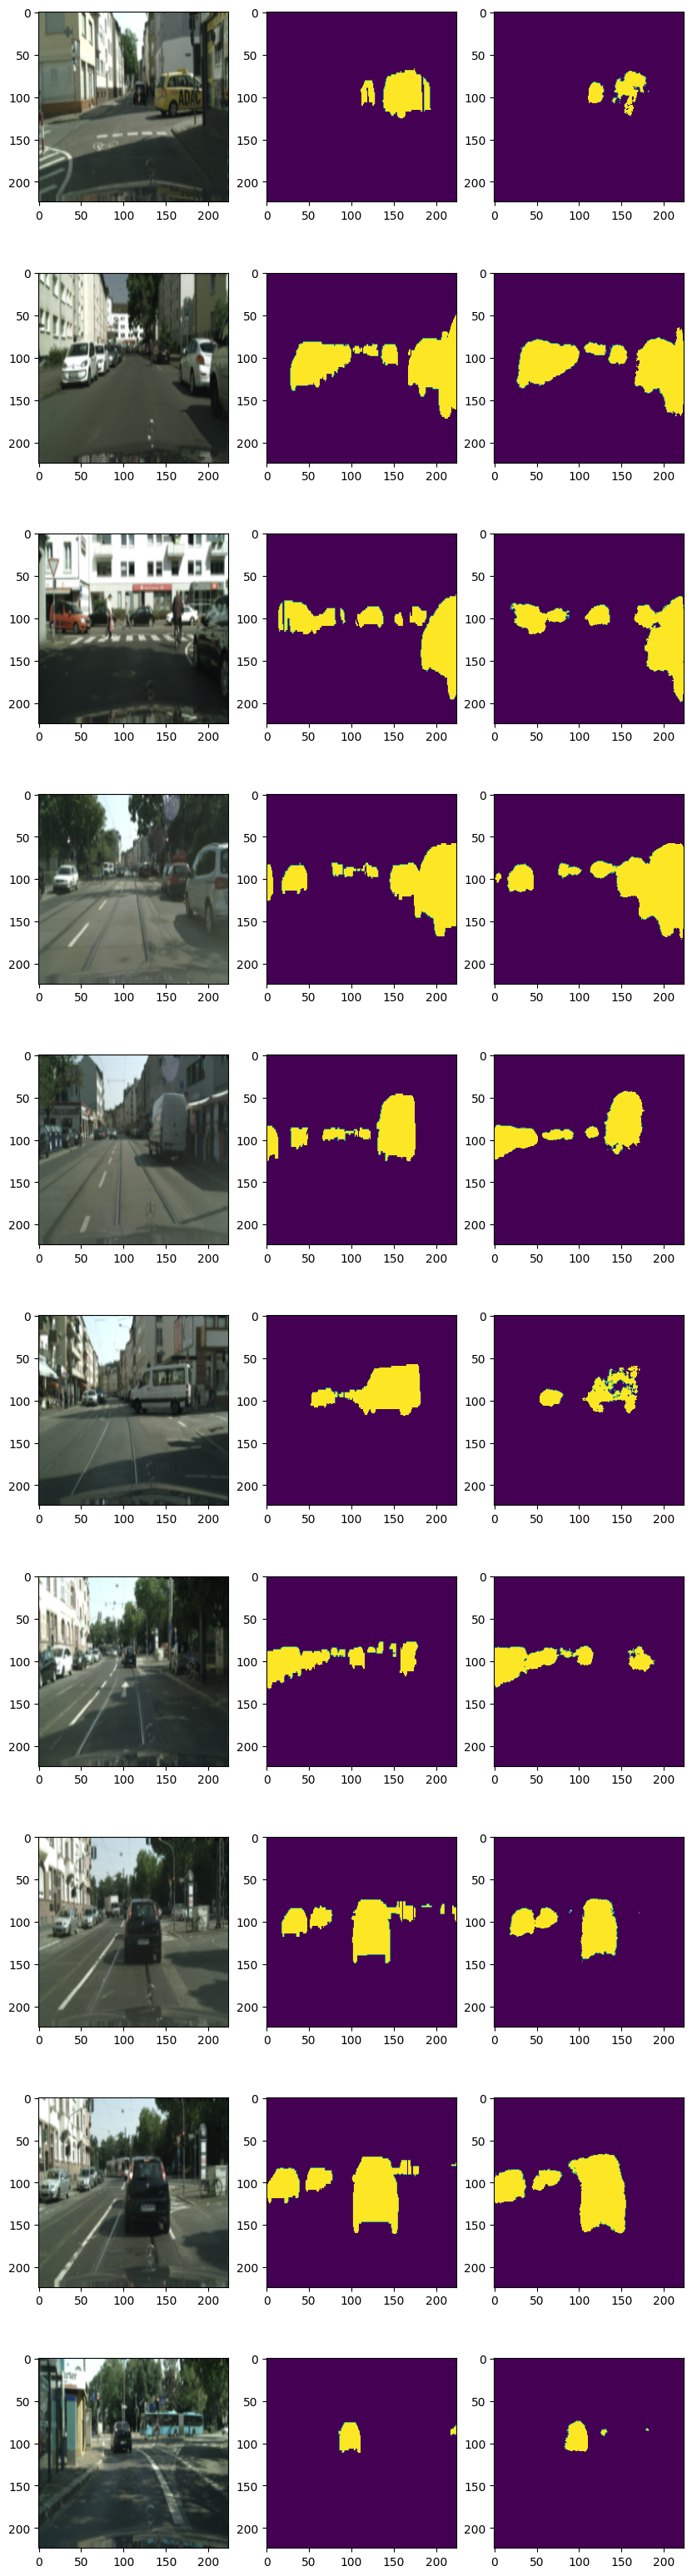

In [172]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=10, ncols=3, figsize=(10, 40))

imgs, labels = next(iter(test_dataloader))
imgs = imgs.to(device)
outputs = model(imgs.float())
for i in range(10):
    img = imgs[i]
    label = labels[i]
    pred = outputs.argmax(1)[i]

    img = img.permute(1,2,0)
    axes[i, 0].imshow(img.cpu().numpy())

    axes[i,1].imshow(label.cpu().numpy())

    axes[i,2].imshow(pred.cpu().numpy())